# ED-Copilot: Data Preprocessing

Este notebook executa e visualiza o pipeline de preprocessamento dos dados MIMIC-IV-ED.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data import MIMICLoader, EDPreprocessor, FeatureEngineer, OutcomeLabeler

# Configurar visualizações
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%load_ext autoreload
%autoreload 2

## 1. Carregar Dados

### 💡 Estratégia de Carregamento

Para evitar problemas de memória, este notebook:
1. ✅ Carrega dados essenciais (ED stays, pacientes, admissions, triagem)
2. ⏭️ **NÃO** carrega `labevents.csv` automaticamente (arquivo muito grande)
3. 🔧 Permite carregar labevents posteriormente quando necessário
4. 📊 Oferece opção de trabalhar com amostras menores para testes

**Recomendação**: Execute o notebook completo sem labevents primeiro, depois carregue labs conforme necessário.

In [2]:
loader = MIMICLoader(data_root='../data/raw')
# data = loader.load_all(
#     load_labs=True, 
#     load_vitals=True, 
#     lab_strategy='filtered',
#     sample_size=None
# )

data = loader.load_all(
    load_labs=True,
    load_vitals=True,
    sample_size=None
)

# Ver resumo
loader.get_data_summary()

INFO:src.data.mimic_loader:============================================================
INFO:src.data.mimic_loader:🚀 MIMIC-IV Loader Otimizado v2.0
INFO:src.data.mimic_loader:============================================================
INFO:src.data.mimic_loader:✓ Pacientes: 299,712
INFO:src.data.mimic_loader:✓ ED stays: 425,087
INFO:src.data.mimic_loader:✓ Triage: 425,087
INFO:src.data.mimic_loader:✓ Vitalsign: 1,564,610
INFO:src.data.mimic_loader:✓ Diagnosis: 899,050
INFO:src.data.mimic_loader:✓ Medrecon: 2,987,342
INFO:src.data.mimic_loader:✓ Admissions: 332,101
INFO:src.data.mimic_loader:✓ Diagnoses ICD: 3,797,277
INFO:src.data.mimic_loader:✓ Lab items dict: 1,622
INFO:src.data.mimic_loader:
INFO:src.data.mimic_loader:🧪 CARREGANDO LABEVENTS - Estratégia: FILTERED
INFO:src.data.mimic_loader:============================================================
INFO:src.data.mimic_loader:🎯 Modo FILTERED: 56 itemids relevantes
INFO:src.data.mimic_loader:   Chunk  10: 4,956,997 labs | Taxa: 235,

,Dataset,Registros,Colunas,Memória (MB)
0,patients,"299,712",5,4.6
1,edstays,"425,087",9,68.1
2,triage,"425,087",11,23.7
3,vitalsign,"1,564,610",11,167.5
4,diagnosis,"899,050",6,15.0
5,medrecon,"2,987,342",9,152.2
6,admissions,"332,101",16,98.6
7,diagnoses_icd,"3,797,277",4,70.8
8,d_labitems,"1,622",4,0.1
9,labevents,"58,682,574",6,1399.1


## 2. Preprocessamento

In [3]:
preprocessor = EDPreprocessor(data)

print("\n📋 Colunas disponíveis por dataset:")
print(preprocessor.get_column_availability())

# ====== CÉLULA 4: Aplicar Filtros ======
print("\n🔧 Aplicando filtros do paper...")

df_filtered = preprocessor.apply_filters()

print(f"\n✅ Dados filtrados: {len(df_filtered):,} registros")
print(f"   Colunas: {df_filtered.shape[1]}")
print(f"   Memória: {df_filtered.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


INFO:src.data.preprocessing:✓ Datasets carregados: ['patients', 'edstays', 'triage', 'vitalsign', 'diagnosis', 'medrecon', 'admissions', 'diagnoses_icd', 'd_labitems', 'labevents', 'icustays']
INFO:src.data.preprocessing:
INFO:src.data.preprocessing:INICIANDO PREPROCESSAMENTO
INFO:src.data.preprocessing:============================================================
INFO:src.data.preprocessing:   ED stays inicial: (425087, 9)
INFO:src.data.preprocessing:   Colunas ED stays: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition']
INFO:src.data.preprocessing:
   Patients shape: (299712, 5)
INFO:src.data.preprocessing:   Patients colunas: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'dod']
INFO:src.data.preprocessing:   Gender em patients: {'F': 158553, 'M': 141159}
INFO:src.data.preprocessing:   Colunas disponíveis em patients: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'dod']
INFO:src.data.preprocessing:
   Antes d


📋 Colunas disponíveis por dataset:
              Registros Colunas  \
patients         299712       5   
edstays          425087       9   
triage           425087      11   
vitalsign       1564610      11   
diagnosis        899050       6   
medrecon        2987342       9   
admissions       332101      16   
diagnoses_icd   3797277       4   
d_labitems         1622       4   
labevents      58682574       6   
icustays          49020       8   

                                             Colunas disponíveis  
patients        subject_id, gender, anchor_age, anchor_year, dod  
edstays        subject_id, hadm_id, stay_id, intime, outtime,...  
triage         subject_id, stay_id, temperature, heartrate, r...  
vitalsign      subject_id, stay_id, charttime, temperature, h...  
diagnosis      subject_id, stay_id, seq_num, icd_code, icd_ve...  
medrecon       subject_id, stay_id, charttime, name, gsn, ndc...  
admissions     subject_id, hadm_id, admittime, dischtime, dea...  
diagnos

INFO:src.data.preprocessing:
   Após merge com patients:
INFO:src.data.preprocessing:   - df shape: (425087, 13)
INFO:src.data.preprocessing:   - Colunas: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender_x', 'race', 'arrival_transport', 'disposition', 'gender_y', 'anchor_age', 'anchor_year', 'dod']
INFO:src.data.preprocessing:   ✓ Gender após merge: {'F': 229898, 'M': 195189}
INFO:src.data.preprocessing:   ✓ Merge com admissions: 9 colunas
INFO:src.data.preprocessing:   ✓ Merge com triage: 11 colunas
INFO:src.data.preprocessing:   → Shape final após merges: (425087, 31)
INFO:src.data.preprocessing:
1️⃣  Dados iniciais: 425087 ED stays
INFO:src.data.preprocessing:   → Removidos 222071 stays não admitidos
INFO:src.data.preprocessing:2️⃣  Após filtrar admitidos: 203016 stays
INFO:src.data.preprocessing:   → Removidos 0 pacientes < 18 anos
INFO:src.data.preprocessing:3️⃣  Após filtrar adultos: 203016 stays
INFO:src.data.preprocessing:   → Removidos 13858 stays com triagem 


✅ Dados filtrados: 189,158 registros
   Colunas: 38
   Memória: 39.3 MB


In [4]:
print("\n📊 Resumo dos dados filtrados:")
summary = preprocessor.get_filter_summary()
print(summary)


📊 Resumo dos dados filtrados:
                             Valor
Total registros             189158
Pacientes únicos             99346
Idade média (anos)            60.0
Idade min-max               18-103
Sexo masculino (%)            49.0
Sexo feminino (%)             51.0
ED LOS média (h)              9.87
ED LOS mediana (h)            7.37
Lengthened ED Stay (%)         5.9
Mortalidade hospitalar (%)    0.78


In [5]:
df_filtered['gender'].unique()

['F', 'M']
Categories (2, object): ['F', 'M']

## 3. Visualizações Exploratórias

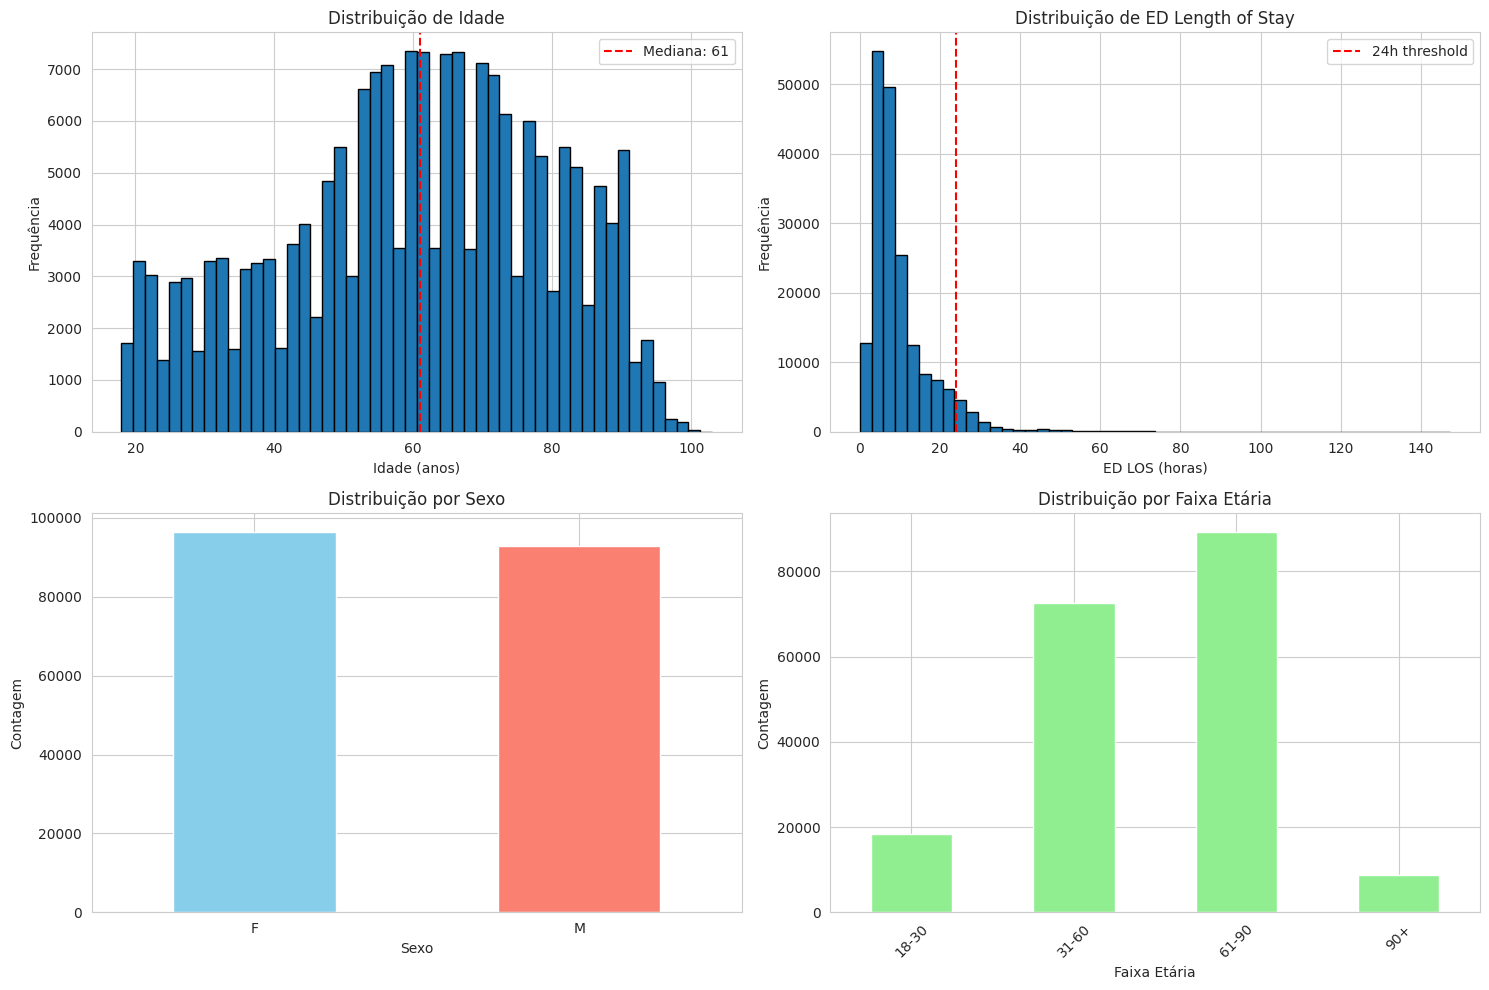

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribuição de idade
if 'age_at_ed' in df_filtered.columns:
    df_filtered['age_at_ed'].hist(bins=50, ax=axes[0, 0], edgecolor='black')
    axes[0, 0].set_xlabel('Idade (anos)')
    axes[0, 0].set_ylabel('Frequência')
    axes[0, 0].set_title('Distribuição de Idade')
    axes[0, 0].axvline(df_filtered['age_at_ed'].median(), 
                       color='red', linestyle='--', label=f"Mediana: {df_filtered['age_at_ed'].median():.0f}")
    axes[0, 0].legend()

# Distribuição de ED LOS
if 'ed_los_hours' in df_filtered.columns:
    df_filtered['ed_los_hours'].hist(bins=50, ax=axes[0, 1], edgecolor='black')
    axes[0, 1].set_xlabel('ED LOS (horas)')
    axes[0, 1].set_ylabel('Frequência')
    axes[0, 1].set_title('Distribuição de ED Length of Stay')
    axes[0, 1].axvline(24, color='red', linestyle='--', label='24h threshold')
    axes[0, 1].legend()

# Distribuição por sexo
if 'gender' in df_filtered.columns:
    gender_counts = df_filtered['gender'].value_counts()
    gender_counts.plot(kind='bar', ax=axes[1, 0], color=['skyblue', 'salmon'])
    axes[1, 0].set_xlabel('Sexo')
    axes[1, 0].set_ylabel('Contagem')
    axes[1, 0].set_title('Distribuição por Sexo')
    axes[1, 0].tick_params(axis='x', rotation=0)

# Distribuição por faixa etária
if 'age_group' in df_filtered.columns:
    age_group_counts = df_filtered['age_group'].value_counts().sort_index()
    age_group_counts.plot(kind='bar', ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_xlabel('Faixa Etária')
    axes[1, 1].set_ylabel('Contagem')
    axes[1, 1].set_title('Distribuição por Faixa Etária')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4. Salvar Dados Preprocessados

Salvando os dados filtrados em formato Parquet para uso posterior.

In [8]:
from pathlib import Path
import os

# Criar diretório de saída se não existir
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Caminho do arquivo de saída
output_path = output_dir / 'ed_preprocessed.parquet'

# Salvar em formato Parquet (mais eficiente que CSV)
print(f"💾 Salvando dados preprocessados...")
df_filtered.to_parquet(output_path, index=False, compression='snappy')

# Verificar tamanho do arquivo
file_size_mb = output_path.stat().st_size / (1024 * 1024)

print(f"\n✅ Dados salvos com sucesso!")
print(f"📁 Arquivo: {output_path}")
print(f"📊 Registros: {len(df_filtered):,}")
print(f"📏 Colunas: {df_filtered.shape[1]}")
print(f"💾 Tamanho do arquivo: {file_size_mb:.2f} MB")
print(f"🗜️  Compressão: Snappy")

# Comparar com tamanho em memória
memory_mb = df_filtered.memory_usage(deep=True).sum() / (1024 * 1024)
compression_ratio = (1 - file_size_mb / memory_mb) * 100
print(f"📉 Taxa de compressão: {compression_ratio:.1f}% (memória: {memory_mb:.1f} MB)")

# Salvar também metadados
metadata_path = output_dir / 'ed_preprocessed_metadata.txt'
with open(metadata_path, 'w', encoding='utf-8') as f:
    f.write("ED-COPILOT: METADADOS DO DATASET PREPROCESSADO\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Data/Hora: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Registros: {len(df_filtered):,}\n")
    f.write(f"Colunas: {df_filtered.shape[1]}\n")
    f.write(f"Tamanho do arquivo: {file_size_mb:.2f} MB\n\n")
    
    f.write("COLUNAS:\n")
    f.write("-" * 60 + "\n")
    for i, col in enumerate(df_filtered.columns, 1):
        dtype = df_filtered[col].dtype
        non_null = df_filtered[col].notna().sum()
        null_pct = (1 - non_null / len(df_filtered)) * 100
        f.write(f"{i:3d}. {col:30s} | {str(dtype):15s} | {null_pct:5.1f}% nulos\n")
    
    f.write("\n" + "=" * 60 + "\n")
    f.write("\nESTATÍSTICAS BÁSICAS:\n")
    f.write("-" * 60 + "\n")
    
    summary = preprocessor.get_filter_summary()
    f.write(summary.to_string())

print(f"\n📝 Metadados salvos em: {metadata_path}")

💾 Salvando dados preprocessados...

✅ Dados salvos com sucesso!
📁 Arquivo: ../data/processed/ed_preprocessed.parquet
📊 Registros: 189,158
📏 Colunas: 38
💾 Tamanho do arquivo: 13.01 MB
🗜️  Compressão: Snappy
📉 Taxa de compressão: 66.9% (memória: 39.3 MB)

📝 Metadados salvos em: ../data/processed/ed_preprocessed_metadata.txt
